# MWE - Optimized Healthcare Simulation
This notebook simulates a constrained healthcare system with patient flow across disease pathways and clinical interventions.

## Imports

In [ ]:
# Step 1: Imports and Initial Setup
import numpy as np
import pandas as pd
import random

# Data manipulation and analysis
from collections import defaultdict
import heapq

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go #Sankey diagram
# you;ll need nbformat >= 4.2.0 for plotly to work in jupyter notebooks

# Set random seed for reproducibility if required
np.random.seed(0)
random.seed(0)

# Step 1 Define Classes

## Patient Class
- __ init __
- progress disease
- clinical_dec
- apply_action
- score_outcome

In [2]:
# Step 2: Define Patient Class with Time-Dependent Variables
class Patient:
    """
    Represents a patient in the healthcare simulation.

    Attributes:
        pid (int): Unique identifier for the patient.
        age (int): Age of the patient.
        sex (str): Gender of the patient ('M' or 'F').
        diseases (dict): Dictionary indicating the presence of diseases across pathways.
        clinical (dict): Clinical variables and their current values.
        outcomes (dict): Metrics for queue and clinical penalties.
        history (list): List of actions the patient has undergone.
        queue_time (int): Total time the patient has spent in queues.
    """
    
    def __init__(self, pid):
    
        self.pid = pid
        self.age = np.random.randint(18, 90)
        if 18 <= self.age < 45:
            self.age_group = 'young'
        elif 45 <= self.age <= 65:
            self.age_group = 'middle'
        else:
            self.age_group = 'elderly'
        self.sex = np.random.choice(['M', 'F'])
        self.diseases = {f'P{p}': False for p in range(NUM_PATHWAYS)}
        self.comorbidities = 0
        self.clinical = {k: np.random.normal(v, 0.4*v) for k, v in IDEAL_CLINICAL_VALUES.items()}
        self.sickness = 0
        self.outcomes = {'queue_penalty': 1000000, 'clinical_penalty': 100}
        self.history = []
        self.queue_time = 0
            
    # --- Patient disease occurrence ---
    @staticmethod
    def progress_diseases(patient, pathway):
        """
        Simulates disease occurrence for a patient in a given pathway.

        This method performs two main functions:
        1. Disease Occurrence: With a fixed probability, the patient may acquire a new disease in the specified pathway.
        If disease occurs, the patient's disease status for the pathway is set to True, an initial action is assigned,
        and the action is recorded in the patient's history.

        Args:
            patient (Patient): The patient object whose state is being updated.
            pathway (str): The pathway code (e.g., 'P0', 'P1', etc.) to check for disease progression.
        """

        if patient.diseases[pathway] == False and np.random.rand() < PROBABILITY_OF_DISEASE:
            patient.diseases[pathway] = True
            start_action = random.choice(input_actions)
            actions[start_action].assign(patient)
            patient.history.append((start_action,pathway))   
        patient.comorbidities = sum(patient.diseases.values())
            
    # --- Patient clinical variable updates ---
    @staticmethod
    def clinical_decay(patient):
        """
        Simulates the natural decay of clinical variables over time.
        This method reduces each clinical variable by a small amount, simulating the natural decline in health metrics.
        Args:
            patient (Patient): The patient object whose clinical variables are being updated.
        """
        for k in patient.clinical:
            ideal = IDEAL_CLINICAL_VALUES[k]
            current = patient.clinical[k]
            # Determine direction away from ideal
            if current >= ideal:
                patient.clinical[k] += abs(np.random.normal(0.5, 0.1)) # Move further above ideal
            else:
                patient.clinical[k] -= abs(np.random.normal(0.5, 0.1)) # Move further below ideal
        
        # Ensure clinical variables remain within a reasonable range
        for k in patient.clinical:
            patient.clinical[k] = max(0.4*IDEAL_CLINICAL_VALUES[k], min(patient.clinical[k], IDEAL_CLINICAL_VALUES[k]*1.6))
        
    # --- Patient actions and outcomes ---
    def apply_action(self, effect):
        """
        Applies the effects of an action to the patient's clinical variables.
        
        Args:
            effect (dict): Dictionary of clinical variable changes.
        """
        for k, v in effect.items():
            if k in self.clinical:
                if self.clinical[k] < IDEAL_CLINICAL_VALUES[k]:
                    self.clinical[k] = self.clinical[k] + v
                else:
                    self.clinical[k] = self.clinical[k] - v

    # --- Patient scoring and outcome calculation ---
    def score_outcomes(self):
        """
        Updates the patient's outcome metrics based on their current state. 
        The queue penalty is reduced based on the time spent in the queue, and the clinical penalty is calculated based on the clinical variables vs user set ideal clinical variables.
        """
        
        self.outcomes['queue_penalty'] = max(0, self.outcomes['queue_penalty'] - self.queue_time)
        self.outcomes['clinical_penalty'] = sum(
        abs(self.clinical[k] - IDEAL_CLINICAL_VALUES[k]) for k in self.clinical if k in IDEAL_CLINICAL_VALUES)
        if 0 <= self.outcomes['clinical_penalty'] < 110:
            self.sickness = 0
        elif 110 <= self.outcomes['clinical_penalty'] <= 160:
            self.sickness = 1
        else:
            self.sickness = 2
    

## Action Class
- __ init __
- assign
- update_log
- execute
- handle_output_action

In [3]:
# Step 3: Define Actions
class Action:
    """
    Represents an action or intervention in the healthcare simulation.

    Attributes:
        name (str): The name of the action.
        base_capacity (int): Starting value.
        capacity (int): The maximum number of patients the action can handle at a time.
        effect (dict): A dictionary specifying the effect of the action on clinical variables.
        cost (int): The cost associated with performing the action.
        duration (int): The duration of the action in time steps.
        queue (list): A priority queue of patients waiting for the action.
        schedule (list): A record of the number of patients served at each time step.
    """
    
    def __init__(self, name, base_capacity, effect, cost, duration):
        self.name = name
        self.base_capacity = base_capacity
        self.capacity = base_capacity
        self.effect = effect
        self.cost = cost
        self.duration = duration
        self.queue = []  # Use a priority queue
        self.in_progress = []  # List of (patient, remaining_time)
        self.schedule = []
        
    def update_capacity(self, step):
        # Example: capacity reduced by 30% on weekends
        
        if step % 7 in [5, 6]:
            self.capacity = int(self.base_capacity * 0.7)
        # Example: random 10–20% fluctuation
        fluctuation = np.random.uniform(0.8, 1.2)
        self.capacity = int(self.base_capacity * fluctuation)

    def assign(self, patient):
        """
        Assigns a patient to the action's queue based on their priority.
        - Patients with lower clinical_penalty (worse clinical outcome) and lower queue_penalty (longer wait) get a lower priority_score.
        - Since heapq is a min-heap, patients with the lowest priority_score are popped first and served earlier.
        - This ensures that sicker patients and those who have waited longer are prioritized in the queue.
        """
        # Combine priority level and outcomes score for sorting
        priority_score = patient.outcomes['clinical_penalty'] + 0.005*patient.outcomes['queue_penalty']
        heapq.heappush(self.queue, (priority_score, patient.pid, patient))
        
    
    def update_log(self, patient, pathway, current_action):
        
        # Determine previous action from patient history
        prev_action = pw.get_last_action_on_pathway(patient)
        
        activity_log.append({
            "pathway_code": pathway.name,
            "pathway_flag": patient.diseases[pathway.name],
            "patient_id": patient.pid,
            "simulation_time": step,
            "previous_action": prev_action,
            "action_name": current_action,
            "next_action": self.name
            
        })

    
    def execute(self):
        """
        Processes patients assigned to this action for the current simulation step.

        - Updates the status of patients currently in progress, moving those who have completed the action to a finished list.
        - Moves patients from the queue to in-progress if there is available capacity, applies the action's clinical effects, and updates their outcomes.
        - Tracks the number of patients served at this step in the schedule.
        - Returns a tuple containing:
            - finished_patients: List of patients who have completed this action during this step.
            - cost: Total cost incurred by the action for this step (number of finished patients multiplied by the action's cost).
        """
        
        # Update in-progress patients
        finished_patients = []
        new_in_progress = []
        for patient, remaining_time in self.in_progress:
            if remaining_time > 1:
                new_in_progress.append((patient, remaining_time - 1))
            else:
                finished_patients.append(patient)
        self.in_progress = new_in_progress

        # Move patients from queue to in-progress if capacity allows
        available_slots = self.capacity - len(self.in_progress)
        for _ in range(available_slots):
            if self.queue:
                _, _, patient = heapq.heappop(self.queue)
                patient.queue_time += 1  # Still count as queue time until assigned?
                patient.apply_action(self.effect)
                patient.score_outcomes()
                self.in_progress.append((patient, self.duration))
        self.schedule.append(len(self.in_progress))

        # Return finished patients and cost
        return finished_patients, len(finished_patients) * self.cost
    
    def handle_output_action(patient, pathway, next_action):
        """
        Handles the logic when a patient reaches an output action in a pathway.

        This method sets the disease status for the specified pathway to False, indicating
        that the patient has completed the pathway or exited the system. It also allows for
        any additional cleanup or transition logic when a patient reaches an output action.

        Args:
            patient (Patient): The patient object being processed.
            pathway_code (str): The code of the pathway being updated.
            next_action (str): The name of the output action (typically the final action in the pathway).
        """
        # Set disease to False for this pathway
        if pathway.name in patient.diseases:
            patient.diseases[pathway.name] = False
            next_action = None
            
    def reset(self):
        self.queue = []
        self.in_progress = []
        self.schedule = []
    
    

## Pathway Class
- __ init __
- next_action
- generate_transition_matrix
- get_last_action_on_pathway
- get_current_action_on_pathway

In [4]:
# Step 4: Define Pathways
class Pathway:
    """
    Represents a healthcare pathway with transitions and thresholds.

    Attributes:
        name (str): The name of the pathway.
        transitions (dict): A dictionary defining possible transitions between actions.
        thresholds (dict): A dictionary defining thresholds for transitions based on clinical variables.
    """
    
    def __init__(self, name, transitions, thresholds):
        self.name = name
        self.transitions = transitions
        self.thresholds = thresholds
    
    def next_action(self, patient, step, NUM_STEPS):
        """
        Determines and assigns the next action for a patient within this pathway.

        This method:
            - Identifies the patient's current action on the pathway.
            - Retrieves valid next actions based on the pathway's transition matrix.
            - Selects the next action 
            - Assigns the patient to the chosen action and updates the activity log and patient history.

        Args:
            patient (Patient): The patient object whose next action is being determined.
            major_step (int): The current major step or episode in the simulation.

        Returns:
            tuple or None:
                - None if no valid next action is available or the patient is not active on this pathway.
        """  
        current_action = self.get_current_action_on_pathway(patient)
        if current_action is None or self.name not in patient.diseases or not patient.diseases[self.name]:
            return None

        valid_actions = []
        if self.name in self.transitions and current_action in self.transitions[self.name]:
            valid_actions = self.transitions[self.name][current_action]
        if not valid_actions:
            return None

        # PLACEHOLDER - SELCT NEXT ACTION RANDOMLY                     
        next_a = random.choice(valid_actions)

        # Assign patient to the chosen action and update log/history
        actions[next_a].assign(patient)
        actions[next_a].update_log(patient, self, current_action)
        patient.history.append((next_a, self.name))
        return next_a
    
    @staticmethod
    def generate_transition_matrix(num_pathways, num_actions, input_actions=None, output_actions=None, intermediate_actions=None):
        """
        Generates a transition matrix for healthcare pathways.

        Args:
            num_pathways (int): Number of distinct pathways to generate.
            num_actions (int): Number of actions available in each pathway.
            input_actions (list, optional): List of action names considered as input actions (entry points).
            output_actions (list or str, optional): List or single action name(s) considered as output actions (exit points).
            intermediate_actions (list, optional): List of action names considered as intermediate actions.

        Returns:
            dict: A nested dictionary where each key is a pathway name (e.g., 'P0'), and each value is a dictionary mapping
                action names to lists of possible next actions. Output actions have empty lists as next actions.
        """
        transition_matrix = {}
        for p in range(num_pathways):
            pathway = f'P{p}'
            actions_list = [f'a{i}' for i in range(num_actions)]
            transitions = {}
            for action in actions_list:
                if action in output_actions:
                    next_action = []  # Output action has no next actions
                elif action in input_actions:
                    next_action = random.sample(actions_list, random.randint(1, NUM_ACTIONS)) #random combinations
                else:
                    actions_list_no_input = [a for a in actions_list if a not in input_actions]
                    next_action = random.sample(actions_list_no_input, random.randint(1, NUM_ACTIONS-len(input_actions))) #random combinations but no input actions
                transitions[action] = next_action
            transition_matrix[pathway] = transitions                
        return transition_matrix
    
    def get_last_action_on_pathway(self, patient):
        """
        Returns the last action taken by the patient on the specified pathway.
        If no such action exists, returns None.
        """
        found_current = False
        for action, pw in reversed(patient.history):
            if pw == self.name:
                if found_current:
                    return action
                found_current = True
        return None

    def get_current_action_on_pathway(self, patient):
        """
        Returns the most recent (current) action taken by the patient on the specified pathway.
        If no such action exists, returns None.
        """
        for action, pw in reversed(patient.history):
            if pw == self.name:
                return action
        return None
    
    def reset(self):
        """
        Resets the pathway's state, clearing any history or progress.
        This is useful for starting a new simulation or resetting the pathway.
        """
        self.transitions = {}
        self.thresholds = {}


# Step 2: Build the System

In [5]:
# Step 5: Simulate System
""" 
This step initializes the simulation by creating a list of patients and defining actions with their respective capacities, effects, costs, and durations.
It also sets up pathways with transition thresholds based on clinical variables.
The resulting `actions` dictionary contains 10 `Action` objects, each with unique configurations based on the value of `i`.
The thresholds dictionary defines the conditions under which patients can transition from one action to another, based on their clinical variables.
The pathways list contains 10 `Pathway` objects, each with its own set of transitions and thresholds.
"""
def initialize_patients(NUM_PATIENTS=100):
    patients = [Patient(i) for i in range(NUM_PATIENTS)]
    return patients

def initialize_simulation(NUM_PATIENTS=100, NUM_PATHWAYS=10, NUM_ACTIONS=10, BASE_CAPACITY=5, IDEAL_CLINICAL_VALUES=None, PROBABILITY_OF_DISEASE=0.1, input_actions='a0', output_actions='a9'): 
    actions = {
        f'a{i}': Action(
            f'a{i}', 
            base_capacity=BASE_CAPACITY,
            effect = {k: (np.random.normal(2,0.05) if j == i % 5 else 0) for j, k in enumerate(IDEAL_CLINICAL_VALUES.keys())},
            cost=np.random.randint(20, 100), 
            duration=np.random.randint(1, 3)        #removes_disease=random.rand() < 0.1
        )
        for i in range(NUM_ACTIONS)
    }

    intermediate_actions = [a for a in actions if a not in input_actions + [output_actions]]

    threshold_matrix = {
        f'P{p}': {
            f'a{i}': {
                **{k: np.random.normal(v, 5) for k, v in IDEAL_CLINICAL_VALUES.items()},
                'age': np.random.randint(18, 65),
                'rand_factor': np.random.uniform(0.2, 0.8)
            }
            for i in range(NUM_ACTIONS)
        }
        for p in range(NUM_PATHWAYS)
    }

    transition_matrix = Pathway.generate_transition_matrix(
        NUM_PATHWAYS, NUM_ACTIONS, input_actions, output_actions, intermediate_actions
    )

    pathways = [Pathway(f'P{i}', transition_matrix, threshold_matrix) for i in range(NUM_PATHWAYS)]
    
    return actions, pathways, threshold_matrix, transition_matrix

# Step 4: Run the Simulation

In [6]:
# Step 6: Run Simulation with Queues
"""
This step simulates the flow of patients through the healthcare system. The simulation tracks the clinical variables of each patient, 
determines their next actions based on predefined pathways, and executes those actions while calculating the associated costs.

1. A loop runs for `NUM_STEPS`, representing each time step in the simulation.
2. The `progress_disease()` method is called to simulate the natural decline in their clinical variables over time and occurence of diseases.
3. For each patient and each pathway in the `pathways` list:
    - The `next_action()` method is called to determine the next action for the patient based on their clinical variables and the pathway's thresholds.
    - If a valid next action is identified and exists in the `actions` dictionary, the patient is assigned to the action's queue, and the action is added to the patient's history.
4. For each action in the `actions` dictionary:
    - The `execute()` method is called to process patients in the action's queue, apply the action's effects, and calculate the cost incurred.
    - The cost for the action is added to the `step_cost`.
5. The total cost for the current time step (`step_cost`) is appended to the `system_cost` list.

"""

NUM_PATIENTS = 2
NUM_PATHWAYS = 3
NUM_ACTIONS = 10
NUM_STEPS = 365
BASE_CAPACITY = 2
PROBABILITY_OF_DISEASE = 0.15

# --- Ideal clinical values ---
IDEAL_CLINICAL_VALUES = {
    'bp': 120,
    'glucose': 90,
    'bmi': 22,
    'oxygen': 98,
    'mental_health': 80,
}

input_actions = ['a0', 'a1']  # Two standard input actions
output_actions = 'a9'       # Standard output action
actions, pathways, threshold_matrix, transition_matrix = initialize_simulation(NUM_PATIENTS, NUM_PATHWAYS, NUM_ACTIONS, BASE_CAPACITY, IDEAL_CLINICAL_VALUES, PROBABILITY_OF_DISEASE, input_actions, output_actions)
patients = initialize_patients(NUM_PATIENTS)

system_cost = {}
sum_cost = 0
activity_log = []
for step in range(NUM_STEPS):
    step_cost = 0
    rewards = []
    for act in actions.values():
        act.update_capacity(step)
    for p in patients:
        for pw in pathways:
            if not p.diseases[pw.name]:
                Patient.progress_diseases(p, pw.name)
                continue
            Patient.clinical_decay(p) # Patient gets a little worse per pathway they are on
            next_a = pw.next_action(p, step, NUM_STEPS)
            if next_a == output_actions:
                Action.handle_output_action(p, pw, next_a)
            action_cost = actions[next_a].cost if next_a in actions else 0
            reward = - 0.25 * action_cost
            rewards.append(reward)
    for act in actions.values():
        in_progress, cost = act.execute()
        step_cost += cost
    sum_cost += step_cost
    system_cost[step] = sum_cost   


# Visualise the System Created:
- Patients
- Action Effects
- Pathways (tabular and graphical)
- Thresholds for the pathways

In [7]:
# Display the first few patients
for i, patient in enumerate(patients[:3]):
    print(f"Patient {i+1}:")
    print(f"  ID: {patient.pid}")
    print(f"  Age: {patient.age}")
    print(f"  Age Group: {patient.age_group}")
    print(f"  Sex: {patient.sex}")
    print(f"  Diseases: {patient.diseases}")
    print(f"  Comorbidities: {patient.comorbidities}")
    print(f"  Clinical Variables: {patient.clinical}")
    print(f"  Clinical Outcome: {patient.outcomes['clinical_penalty']}")
    print(f"  Sickness: {patient.sickness}")
    print()

Patient 1:
  ID: 0
  Age: 76
  Age Group: elderly
  Sex: F
  Diseases: {'P0': True, 'P1': True, 'P2': True}
  Comorbidities: 3
  Clinical Variables: {'bp': 92.67247130644495, 'glucose': 40.07627356560711, 'bmi': 11.557521173609485, 'oxygen': 120.4386585704434, 'mental_health': 126.00516094258968}
  Clinical Outcome: 156.13755346737153
  Sickness: 1

Patient 2:
  ID: 1
  Age: 26
  Age Group: young
  Sex: F
  Diseases: {'P0': True, 'P1': True, 'P2': True}
  Comorbidities: 3
  Clinical Variables: {'bp': 52.10683627647105, 'glucose': 144.0, 'bmi': 24.3796006190307, 'oxygen': 112.98719226297234, 'mental_health': 127.76258840557628}
  Clinical Outcome: 187.02254501110826
  Sickness: 2



In [8]:
# Display the first two actions
for action_name, action_obj in list(actions.items())[:10]:
    print(f"Action Name: {action_name}")
    print(f"  Base_Capacity: {action_obj.base_capacity}")
    print(f"  Capacity: {action_obj.capacity}")
    print(f"  Effect: {action_obj.effect}")
    print(f"  Cost: {action_obj.cost}")
    print(f"  Duration: {action_obj.duration}")
    print()

Action Name: a0
  Base_Capacity: 2
  Capacity: 1
  Effect: {'bp': 2.0882026172983834, 'glucose': 0, 'bmi': 0, 'oxygen': 0, 'mental_health': 0}
  Cost: 87
  Duration: 2

Action Name: a1
  Base_Capacity: 2
  Capacity: 1
  Effect: {'bp': 0, 'glucose': 2.020007860418361, 'bmi': 0, 'oxygen': 0, 'mental_health': 0}
  Cost: 87
  Duration: 2

Action Name: a2
  Base_Capacity: 2
  Capacity: 2
  Effect: {'bp': 0, 'glucose': 0, 'bmi': 2.0933778995074985, 'oxygen': 0, 'mental_health': 0}
  Cost: 56
  Duration: 2

Action Name: a3
  Base_Capacity: 2
  Capacity: 2
  Effect: {'bp': 0, 'glucose': 0, 'bmi': 0, 'oxygen': 1.9511361060061794, 'mental_health': 0}
  Cost: 90
  Duration: 1

Action Name: a4
  Base_Capacity: 2
  Capacity: 2
  Effect: {'bp': 0, 'glucose': 0, 'bmi': 0, 'oxygen': 0, 'mental_health': 1.994839057410322}
  Cost: 59
  Duration: 2

Action Name: a5
  Base_Capacity: 2
  Capacity: 1
  Effect: {'bp': 2.0205299250969184, 'glucose': 0, 'bmi': 0, 'oxygen': 0, 'mental_health': 0}
  Cost: 66
  D

# Step 5: Visualise the Outputs

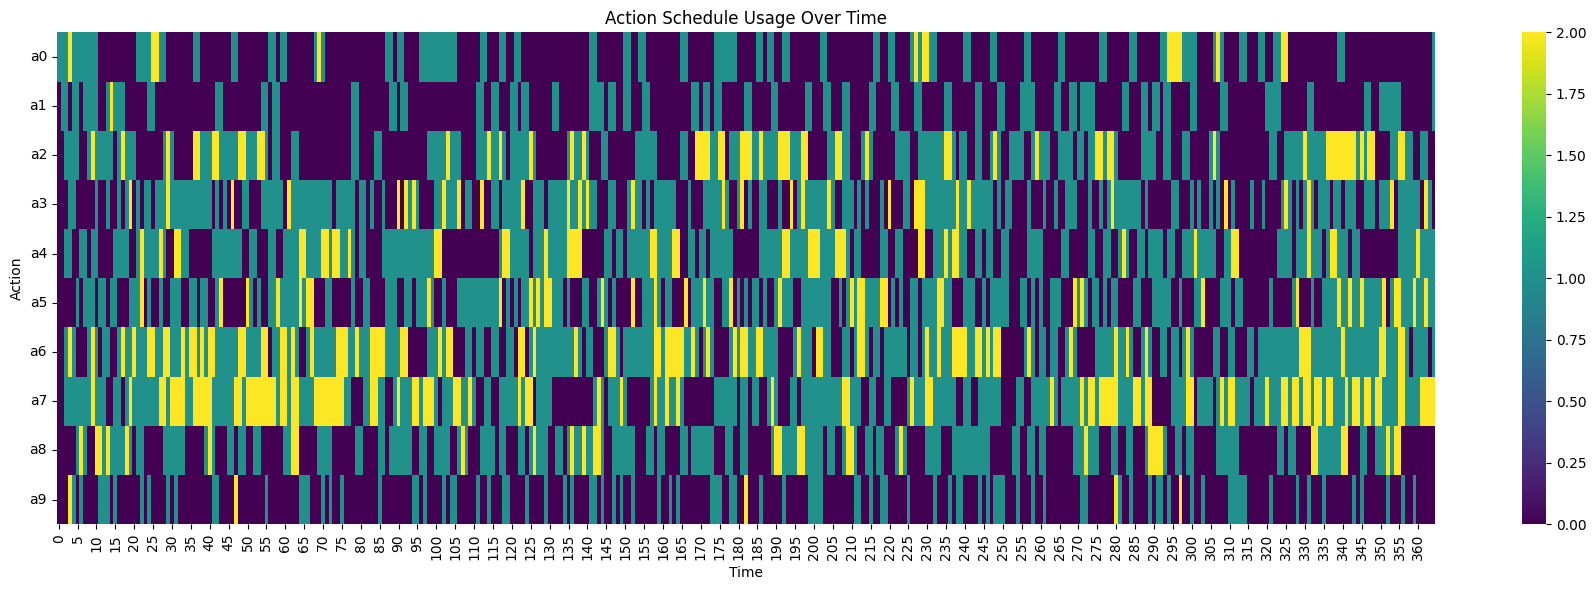

In [9]:
heatmap_data_first = np.array([act.schedule for act in actions.values()])
heatmap_data_last = np.array([act.schedule for act in actions.values()])

fig, axes = plt.subplots(1, 1, figsize=(18, 6), sharey=True)

# First major step
sns.heatmap(
    heatmap_data_first,
    cmap="viridis",
    annot=False,
    cbar=True,
    ax=axes
)
axes.set_title(f"Action Schedule Usage Over Time")
axes.set_xlabel("Time")
axes.set_ylabel("Action")
axes.set_yticks(np.arange(len(actions)) + 0.5)
axes.set_yticklabels(list(actions.keys()), rotation=0)

plt.tight_layout()
plt.show()

In [10]:
print("Total system cost:", sum(system_cost.values()))
print("Average queue penalty:", np.mean([p.outcomes['queue_penalty'] for p in patients]))
print("Average clinical penalty:", np.mean([p.outcomes['clinical_penalty'] for p in patients]))
print("Average wait time:", np.mean([p.queue_time / 30 for p in patients]))
print("Average clinical variables:", {k: np.mean([p.clinical[k] - IDEAL_CLINICAL_VALUES[k] for p in patients]) for k in IDEAL_CLINICAL_VALUES.keys()})

Total system cost: 20471781
Average queue penalty: 711931.5
Average clinical penalty: 171.58004923923988
Average wait time: 25.283333333333335
Average clinical variables: {'bp': np.float64(-47.610346208542), 'glucose': np.float64(2.038136782803555), 'bmi': np.float64(-4.031439103679907), 'oxygen': np.float64(18.71292541670787), 'mental_health': np.float64(46.88387467408298)}


,pathway_code,pathway_flag,patient_id,simulation_time,previous_action,action_name,next_action
3,P1,True,1,2,None,a0,a7
8,P1,True,1,3,a0,a7,a9
15,P1,True,1,5,a9,a1,a8
18,P1,True,1,6,a1,a8,a9
25,P1,True,1,8,a9,a1,a5
29,P1,True,1,9,a1,a5,a6
33,P1,True,1,10,a5,a6,a3
38,P1,True,1,11,a6,a3,a9
50,P1,True,1,15,a9,a1,a5
53,P1,True,1,16,a1,a5,a6


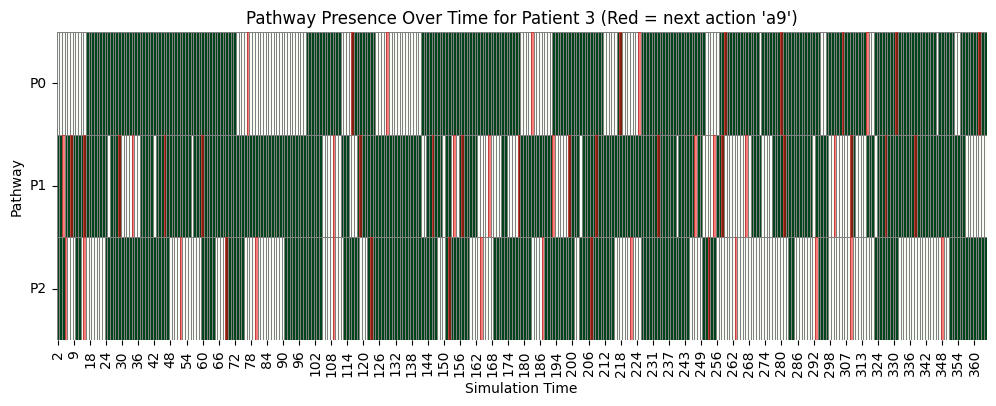

In [11]:
# Display activity_log as a DataFrame (tabular form)
activity_df = pd.DataFrame(activity_log)
# filter to one example patient for clarity
example_patient_df = activity_df[activity_df['patient_id'] == 1]
example_patient_pathway_df = example_patient_df[example_patient_df['pathway_code'] == 'P1']
#example_patient_df = activity_df

display(example_patient_pathway_df.head(20))  

timesteps = sorted(example_patient_df['simulation_time'].unique())
all_pathways = sorted(example_patient_df['pathway_code'].unique())

# Build a DataFrame: index=timesteps, columns=pathways, value=1 if patient is on that pathway at that time
presence_matrix = pd.DataFrame(0, index=timesteps, columns=all_pathways)
for t in timesteps:
    active_pathways = example_patient_df[example_patient_df['simulation_time'] == t]['pathway_code'].unique()
    for pw in active_pathways:
        presence_matrix.loc[t, pw] = 1

plt.figure(figsize=(12, 4))
ax = sns.heatmap(presence_matrix.T, cmap="Greens", cbar=False, linewidths=0.5, linecolor='gray')

# Overlay red squares where the next action is 'a9' for patient 3
for idx, row in example_patient_df.iterrows():
    if row['next_action'] == 'a9':
        # simulation_time is x, pathway_code is y
        x = row['simulation_time'] - 1  # adjust for zero-based index in heatmap
        y = all_pathways.index(row['pathway_code'])
        ax.add_patch(plt.Rectangle((x, y), 1, 1, fill=True, color='red', alpha=0.5, lw=0))

plt.title(f"Pathway Presence Over Time for Patient 3 (Red = next action 'a9')")
plt.xlabel("Simulation Time")
plt.ylabel("Pathway")
plt.yticks(ticks=np.arange(len(all_pathways)) + 0.5, labels=all_pathways, rotation=0)
plt.show()

# Prepare data for Sankey diagram
filtered_df = example_patient_pathway_df.dropna(subset=['action_name','next_action'])
sources = filtered_df['action_name']
targets = filtered_df['next_action']
labels = list(pd.unique(pd.concat([sources, targets])))

# Cut the 'a9' output action from the Sankey diagram
mask = sources != 'a9'
filtered_sources = sources[mask]
filtered_targets = targets[mask]

values = [1] * len(filtered_df)  # Each transition counts as 1

left_nodes = ['a0', 'a1']
right_nodes = ['a9']
middle_nodes = [l for l in labels if l not in left_nodes + right_nodes]
ordered_labels = left_nodes + middle_nodes + right_nodes

# Remap indices for sources and targets
label_indices_ordered = {label: idx for idx, label in enumerate(ordered_labels)}
source_indices_ordered = filtered_sources.map(label_indices_ordered)
target_indices_ordered = filtered_targets.map(label_indices_ordered)

# Set x positions: 0 for left, 1 for right, 0.5 for middle
x_positions = [i / (len(ordered_labels) - 1) for i in range(len(ordered_labels))]
for label in ordered_labels:
    if label in left_nodes:
        x_positions.append(0.0)
    elif label in right_nodes:
        x_positions.append(1.0)
    else:
        x_positions.append(0.5)

# Optional: set y positions to spread nodes vertically
y_positions = [i / (len(ordered_labels) - 1) for i in range(len(ordered_labels))]

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=ordered_labels,
        x=x_positions,
        y=y_positions,
    ),
    link=dict(
        source=source_indices_ordered,
        target=target_indices_ordered,
        value=values,
    ))])

fig.update_layout(title_text="Patient Action Flow (Sankey Diagram)", font_size=10)
fig.show()

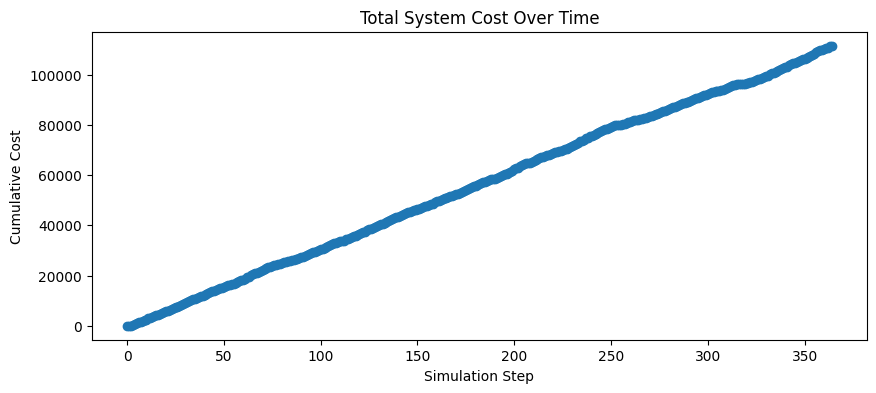

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(list(system_cost.keys()), list(system_cost.values()), marker='o')
plt.title("Total System Cost Over Time")
plt.xlabel("Simulation Step")
plt.ylabel("Cumulative Cost")
plt.show()